# Object Detection using RetinaNet

RetinaNet是用来做目标检测的，参考文献 [Focal Loss for Dense Object Detection](https://arxiv.org/abs/1708.02002) by Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He and Piotr Dollár.

后面将使用 [Keras based implementation](https://github.com/fizyr/keras-retinanet) 训练好的模型来进行测试，为练集为 [COCO object detection dataset](http://cocodataset.org/).

In [ ]:
#正式版本与tensorflow2不兼容，安装一个分支
%pip install -q git+https://github.com/fizyr/keras-retinanet
# git clone https://github.com/fizyr/keras-retinanet
#pip install .

加载预训练好的模型

In [3]:
#所有预训练好的模型可以从这里下载：https://github.com/fizyr/keras-retinanet/releases
from urllib.request import urlretrieve
import os

PRETRAINED_MODEL_NAME = "resnet50_coco_best_v2.1.0.h5"
BACKBONE_NAME = 'resnet50'
PRETRAINED_BASE_URL = (
    "https://github.com/fizyr/keras-retinanet/"
    "releases/download/0.5.1/")

if not os.path.exists(PRETRAINED_MODEL_NAME):
    model_url = PRETRAINED_BASE_URL + PRETRAINED_MODEL_NAME
    print(f"Downloading {model_url}...")
    urlretrieve(model_url, PRETRAINED_MODEL_NAME)
    print("done.")

done.


In [4]:
ls -lh *.h5

-rw-rw-r-- 1 tianliang tianliang 146M Feb  5 23:38 resnet50_coco_best_v2.1.0.h5


In [2]:
from keras_retinanet import models

# load retinanet model
model = models.load_model(PRETRAINED_MODEL_NAME, backbone_name=BACKBONE_NAME)

Using TensorFlow backend.


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

/home/tianliang/miniconda3/envs/dl/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
#print(model.summary())

## 对测试图片进行检测（分类和位置）

In [3]:
#labels to names of coco dataset
labels_to_names = {
    0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane',
    5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light',
    10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench',
    14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow',
    20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack',
    25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee',
    30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite',
    34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard',
    37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass',
    41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl',
    46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli',
    51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake',
    56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed',
    60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse',
    65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave',
    69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book',
    74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear',
    78: 'hair drier', 79: 'toothbrush'}


shape: (749, 1333, 3), dtype: float32, range: (-123.67999, 255)
processing time: 0.1s


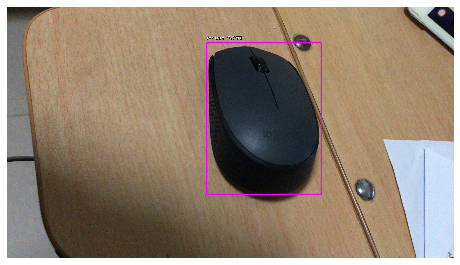

In [12]:
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import matplotlib.pyplot as plt
import time
import cv2
import numpy as np


def detect_and_visualize(image_bgr):
    # copy to draw on
    draw = image_bgr.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image_input = image_bgr.copy()
    image_input = preprocess_image(image_input)
    image_input, scale = resize_image(image_input)
    print(f"shape: {image_input.shape}, dtype: {image_input.dtype}, "
          f"range: {(image_input.min(), image.max())}")

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(
        np.expand_dims(image_input, axis=0))
    print(f"processing time: {time.time() - start:.1f}s")

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.4:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(draw)
    

# load image
image = read_image_bgr('test.png')
detect_and_visualize(image)

## 使用笔记本电脑的摄像头

由于使用的是服务器，没有摄像头，这里只放代码

In [13]:
import cv2
from keras_retinanet.utils.image import read_image_bgr
import matplotlib.pyplot as plt

def camera_grab(camera_id=0, fallback_filename='test.png'):
    camera = cv2.VideoCapture(camera_id)
    try:
        # 连排10张，便摄像头自动调整，期望最后一张有好的效果        
        for i in range(10):
            snapshot_ok, image = camera.read()
        if not snapshot_ok:
            print("WARNING: could not access camera")
            if fallback_filename:
                image = read_image_bgr(fallback_filename)
    finally:
        camera.release()
    return image

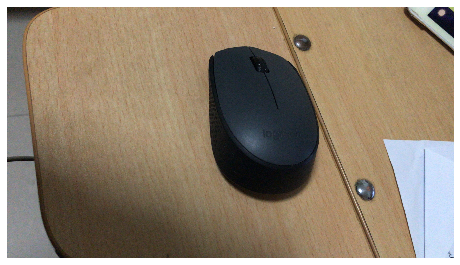

In [14]:
image = camera_grab(camera_id=0)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off');

shape: (749, 1333, 3), dtype: float32, range: (-123.67999, 255)
processing time: 0.1s


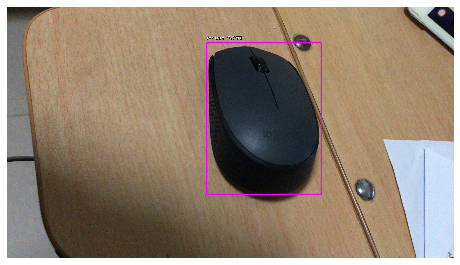

In [15]:
detect_and_visualize(image)